# Impute Weekly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel
import sys
sys.path.append('../conv_imputer')
import gen_synth

In [10]:
data = gen_synth.weekly_daily_signal()
data

E:\Python\HRI\convolution-imputation\research\../conv_imputer\gen_synth.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=24*7*num_weeks, freq='H')


2023-01-02 00:00:00    4.000000
2023-01-02 01:00:00    4.261437
2023-01-02 02:00:00    4.437959
2023-01-02 03:00:00    4.519890
2023-01-02 04:00:00    4.503898
                         ...   
2023-01-29 19:00:00    2.089548
2023-01-29 20:00:00    2.473763
2023-01-29 21:00:00    2.881748
2023-01-29 22:00:00    3.288499
2023-01-29 23:00:00    3.669016
Freq: h, Length: 672, dtype: float64

In [11]:
def get_pivoted_weekly(data):
    df = pd.DataFrame(data)
    df["updatetime"]  = data.index
    df["week_start"] = df["updatetime"].dt.to_period('W-SUN').apply(lambda r: r.start_time)
    df["tow"] = df['updatetime'] - df['week_start']
    pivoted = pd.pivot_table(df, values = 0, index=['week_start'], columns = 'tow').reset_index()
    return pivoted.replace(-666,np.nan)

In [12]:
missing_pattern = gen_synth.uniform_random_missing_patterns(get_pivoted_weekly(data).iloc[:,1:], num_patterns=1, num_missings=30)

In [13]:
data.iloc[missing_pattern[0].flatten().nonzero()] = np.nan # set missing values

In [14]:
data

2023-01-02 00:00:00    4.000000
2023-01-02 01:00:00    4.261437
2023-01-02 02:00:00    4.437959
2023-01-02 03:00:00    4.519890
2023-01-02 04:00:00         NaN
                         ...   
2023-01-29 19:00:00    2.089548
2023-01-29 20:00:00         NaN
2023-01-29 21:00:00    2.881748
2023-01-29 22:00:00    3.288499
2023-01-29 23:00:00    3.669016
Freq: h, Length: 672, dtype: float64

In [6]:
x_size,y_size=11, 5
x_stddev,y_stddev=1.28,0.46
kernel  = Gaussian2DKernel(x_stddev = x_stddev,y_stddev = y_stddev,x_size = x_size,y_size = y_size)

def _impute_conv_array(data, kernel):
    pivoted = get_pivoted_weekly(data).drop(["week_start"],axis=1).values.copy()
    pad_width = max(kernel.shape[0],kernel.shape[1]) //2
    padded = np.pad(pivoted.copy(),mode='edge',pad_width=pad_width)
    interpolated = interpolate_replace_nans(padded, kernel)
    return interpolated[pad_width:-pad_width,pad_width:-pad_width]

def impute(data, kernel):
    pivoted = get_pivoted_weekly(data)
    restored = pivoted.set_index('week_start').unstack([0]).reset_index()
    restored.index = pd.to_datetime(restored.week_start) + pd.to_timedelta(restored['tow'])
    restored = restored.sort_index()
    restored["mean_hr"] = _impute_conv_array(data, kernel).flatten()
    restored["is_imputed"] = restored["mean_hr"] - restored[0]
    restored["is_imputed"] = restored["is_imputed"].replace(np.nan,True)
    restored = restored.drop([0,"tow","week_start"],axis=1)
    return restored

In [7]:
impute(data, kernel)

,mean_hr,is_imputed
2023-01-02 00:00:00,4.000000,0.0
2023-01-02 01:00:00,4.261437,0.0
2023-01-02 02:00:00,4.437959,0.0
2023-01-02 03:00:00,4.519890,0.0
2023-01-02 04:00:00,4.503898,0.0
...,...,...
2023-01-29 19:00:00,2.133671,True
2023-01-29 20:00:00,2.473763,0.0
2023-01-29 21:00:00,2.881748,0.0
2023-01-29 22:00:00,3.288499,0.0


In [8]:
def plot(data, kernel):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(22, 5))
    pivoted = get_pivoted_weekly(data)
    ax1.imshow(pivoted.iloc[:,1:], aspect='auto')
    ax1.set_title('Before')
    ax1.set_xticks(list(range(0,168,24)),["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    ax1.set_yticks(list(pivoted.iloc[::1].index),list(pivoted.iloc[::1].week_start.apply(lambda x: x.strftime('%Y-%m-%d'))))
    imputed = _impute_conv_array(data, kernel)
    ax2.imshow(imputed, aspect='auto')
    ax2.set_title('After')
    ax2.set_xticks(list(range(0,168,24)),["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    ax2.set_yticks(list(pivoted.iloc[::1].index),list(pivoted.iloc[::1].week_start.apply(lambda x: x.strftime('%Y-%m-%d'))))
    fig.suptitle('Data Imputation', fontsize=16)
    plt.figure()

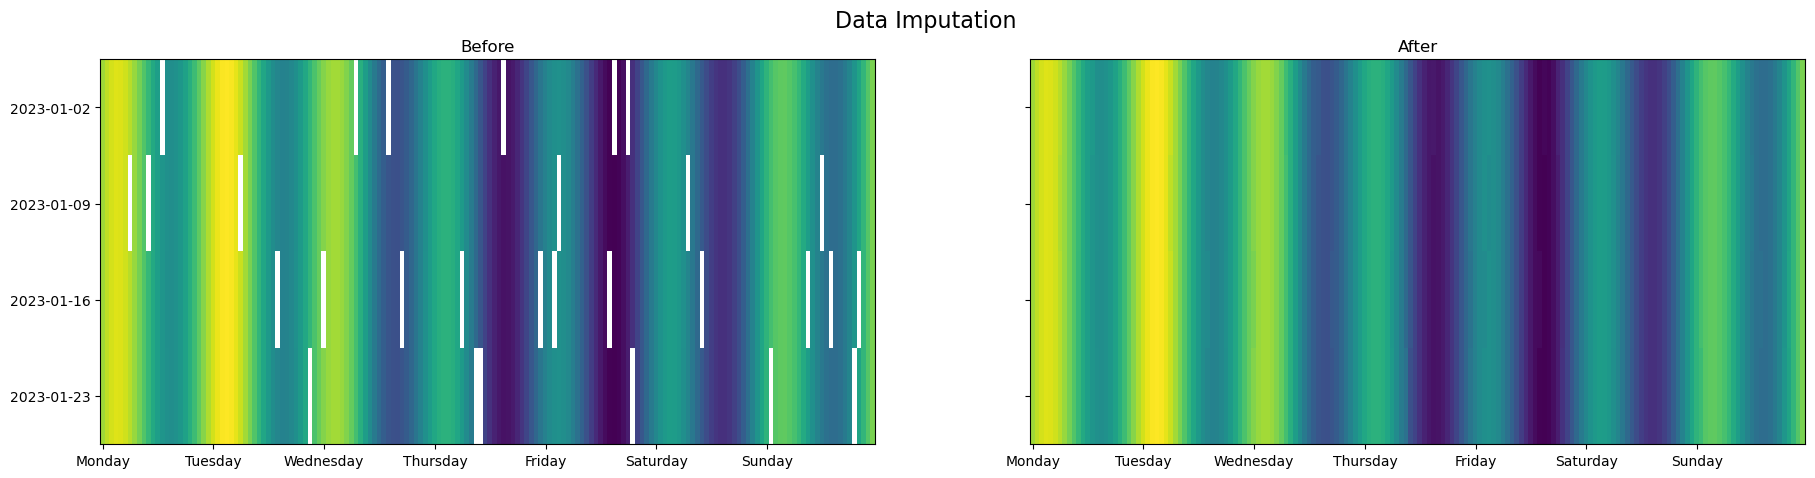

<Figure size 640x480 with 0 Axes>

In [9]:
plot(data, kernel)